### Импортируем нужные билиотеки

In [1]:
import numpy as np
import pandas as pd
import scipy as scipy

from sklearn import model_selection, datasets, linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загрузка датасета с данными

Сразу разобьем данные на тестовые(те, что надо спрогнозировать) и на те, что нужны для обучения модели

In [2]:
train = pd.read_csv('Sarah-gets-a-diamond-data_1.csv', header=2, nrows=4500)

In [3]:
test = pd.read_csv('Sarah-gets-a-diamond-data_1.csv', header=2)

In [4]:
test = pd.concat([test, train]).drop_duplicates(keep=False)

In [5]:
train.head(5)

,ID,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1,1.10,Ideal,H,SI1,VG,EX,GIA,5169.0
1,2,0.83,Ideal,H,VS1,ID,ID,AGSL,3470.0
2,3,0.85,Ideal,H,SI1,EX,EX,GIA,3183.0
3,4,0.91,Ideal,E,SI1,VG,VG,GIA,4370.0
4,5,0.83,Ideal,G,SI1,EX,EX,GIA,3171.0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            4500 non-null   int64  
 1   Carat Weight  4500 non-null   float64
 2   Cut           4500 non-null   object 
 3   Color         4499 non-null   object 
 4   Clarity       4500 non-null   object 
 5   Polish        4500 non-null   object 
 6   Symmetry      4500 non-null   object 
 7   Report        4500 non-null   object 
 8   Price         4500 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 316.5+ KB


Как можно видеть, все данные представлены в нужных типах, переводить ничего не нужно.
Сразу удалим ненужные столбцы в обоих датасетах

In [7]:
train.drop(columns = 'ID', axis = 1, inplace = True)

In [8]:
test.drop(columns = 'ID', axis = 1, inplace = True)

Некоторые данные в датасетах являются категориальными, поэтому для более понятной интерпретации сопоставим их с числами 

In [9]:
cut_map = {'Poor': 1, 
           'Fair': 2, 
           'Good': 3,
           'Very Good': 4,
           'Ideal': 5,
           'Signature-Ideal': 6}

In [10]:
color_map = {'J': 1,
             'I': 2,
             'H': 3,
             'G': 4,
             'F': 5,
             'E': 6,
             'D': 7}

In [11]:
clarity_map = {'SI1': 1, 
               'VS2': 2, 
               'VS1': 3,
               'VVS2': 4,
               'VVS1': 5,
               'IF': 6,
               'FL': 7}

In [12]:
polish_map = {'G': 1, 
              'VG': 2, 
              'EX': 3, 
              'ID': 4}

In [13]:
symmetry_map = {'G': 1,
                'VG': 2,
                'EX': 3,
                'ID': 4}

In [14]:
train['Cut'] = train['Cut'].map(cut_map)
train['Color'] = train['Color'].map(color_map)
train['Polish'] = train['Polish'].map(polish_map)
train['Symmetry'] = train['Symmetry'].map(symmetry_map)
train['Clarity'] = train['Clarity'].map(clarity_map)

In [15]:
test['Cut'] = test['Cut'].map(cut_map)
test['Color'] = test['Color'].map(color_map)
test['Polish'] = test['Polish'].map(polish_map)
test['Symmetry'] = test['Symmetry'].map(symmetry_map)
test['Clarity'] = test['Clarity'].map(clarity_map)

Из столбца Report мы вряд ли что-то сможем взять для модели, поэтому просто определим значения в нем метками

In [16]:
train = pd.get_dummies(train, drop_first=True)


In [17]:
test = pd.get_dummies(test, drop_first=True)


Построим гистограмму и "ящик с усами" для целевой переменной (цены) и проанализируем

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, '"Ящик с усами" цены')

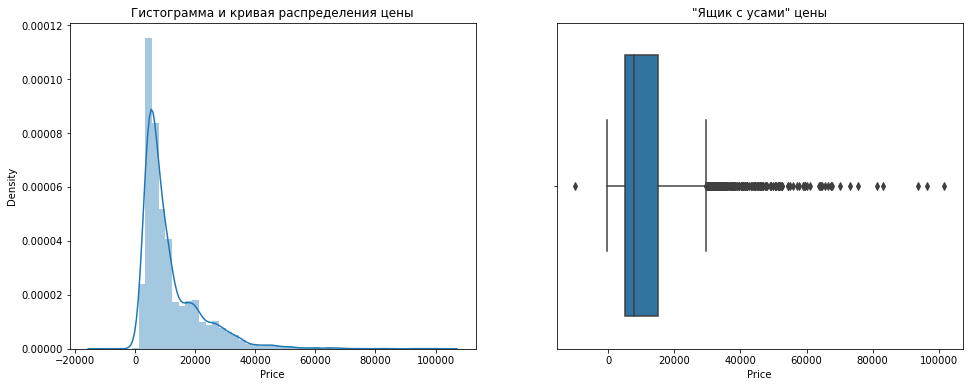

In [18]:
plt.figure(figsize = (16, 6))

pylab.subplot(1,2,1)
sns.distplot(train['Price'])
pylab.title('Гистограмма и кривая распределения цены')

pylab.subplot(1,2,2)
sns.boxplot(train['Price'])
pylab.title('"Ящик с усами" цены')

**Анализ графиков:**
1. В столбце Price присутствуют отрицательные значения;
2. Есть явная асимметрия в правую сторону;
3. По "ящику с усами" можно увидеть:
      * большинство значений больше медианы;
      * много выбросов;
4. Распределение вероятнее всего не нормальное

In [19]:
train['Price'].skew() # посчитаем значение асимметрии

2.393144731645775

Как видим, оно соизмеримо большое для такого количества выбросов

Вначале избавимся от отрицательных значений, заменив их средними

In [20]:
train.loc[train['Price']<=0,'Price'] = np.nan
train['Price'].fillna(train['Price'].mean())
train

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Price,Report_GIA
0,1.10,5.0,3.0,1,2.0,3.0,5169.0,1
1,0.83,5.0,3.0,3,4.0,4.0,3470.0,0
2,0.85,5.0,3.0,1,3.0,3.0,3183.0,1
3,0.91,5.0,6.0,1,2.0,2.0,4370.0,1
4,0.83,5.0,4.0,1,3.0,3.0,3171.0,1
...,...,...,...,...,...,...,...,...
4495,0.90,4.0,5.0,1,2.0,2.0,4095.0,1
4496,1.01,3.0,2.0,1,2.0,2.0,4078.0,1
4497,0.90,4.0,7.0,1,2.0,1.0,4497.0,1
4498,1.21,4.0,4.0,1,2.0,2.0,6439.0,1


Также избавимся от двух выбросов в столбце Carat Weight, которые просто не могут существовать в реальной жизни

In [21]:
train.loc[train['Carat Weight']>=2000,'Carat Weight'] = np.nan
train['Carat Weight'].fillna(train['Carat Weight'].mean())
train

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Price,Report_GIA
0,1.10,5.0,3.0,1,2.0,3.0,5169.0,1
1,0.83,5.0,3.0,3,4.0,4.0,3470.0,0
2,0.85,5.0,3.0,1,3.0,3.0,3183.0,1
3,0.91,5.0,6.0,1,2.0,2.0,4370.0,1
4,0.83,5.0,4.0,1,3.0,3.0,3171.0,1
...,...,...,...,...,...,...,...,...
4495,0.90,4.0,5.0,1,2.0,2.0,4095.0,1
4496,1.01,3.0,2.0,1,2.0,2.0,4078.0,1
4497,0.90,4.0,7.0,1,2.0,1.0,4497.0,1
4498,1.21,4.0,4.0,1,2.0,2.0,6439.0,1


Построим точечные графики зависимости цены от остальных признаков

IndexError: index 2 is out of bounds for axis 0 with size 2

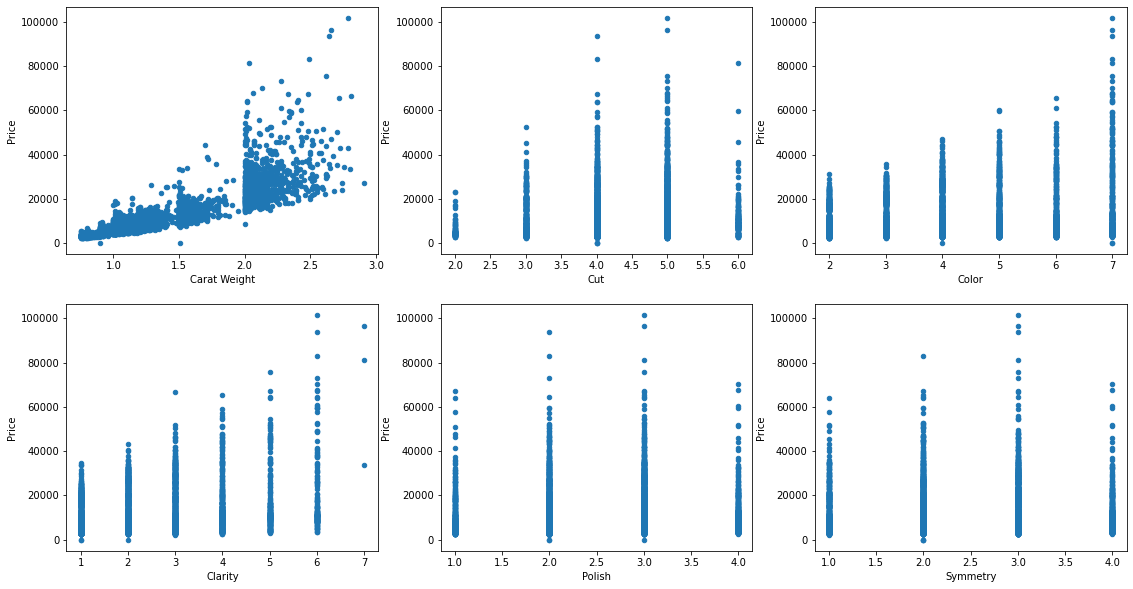

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(19, 10))
for idx, feature in enumerate(train.columns[:-1]):
    train.plot(feature, "Price", subplots=True, kind="scatter", ax=axes[idx // 3, idx % 3])

По графикам видно, что цена больше всего зависит от веса в каратах. Также на цену скорее всего влияют такие параметры как цвет (color) и чистота (clarity). Также по графику зависимости цены от веса в каратах можно наблюдать явление гетероскедастичности (непостоянная дисперсия). Это происходит с каждым сегментом при весах 0-1.5; 1.5-2; 2-3.

Выведем корреляцию столбцов признаков с целевой переменной, т.е. с столбцом цен

In [23]:
print('Корреляция всех величин с ценой:\n',train.corrwith(train['Price'], method='pearson'))

Корреляция всех величин с ценой:
 Carat Weight    0.855152
Cut             0.125591
Color           0.138544
Clarity         0.328784
Polish          0.077507
Symmetry        0.081372
Price           1.000000
Report_GIA      0.007796
dtype: float64


Коэффициенты корреляции показывают что, больше всего на цену влияют вес в каратах, чистота и цвет. В меньшей степени влияют остальные качества. Также в выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

Посмотрим на взаимокорреляцию всех признаков

In [24]:
train.corr(method='pearson')

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Price,Report_GIA
Carat Weight,1.000000,0.066216,-0.127980,0.092978,0.047014,0.045944,0.855152,0.007523
Cut,0.066216,1.000000,-0.043035,0.174237,0.459259,0.560411,0.125591,-0.283586
Color,-0.127980,-0.043035,1.000000,0.029943,-0.058902,-0.074973,0.138544,0.102369
Clarity,0.092978,0.174237,0.029943,1.000000,0.142673,0.137359,0.328784,-0.080743
Polish,0.047014,0.459259,-0.058902,0.142673,1.000000,0.720960,0.077507,-0.570824
Symmetry,0.045944,0.560411,-0.074973,0.137359,0.720960,1.000000,0.081372,-0.566095
Price,0.855152,0.125591,0.138544,0.328784,0.077507,0.081372,1.000000,0.007796
Report_GIA,0.007523,-0.283586,0.102369,-0.080743,-0.570824,-0.566095,0.007796,1.000000


Как видим, слишком коррелирующих столбцов не найдено. Есть столбцы Polish и Symmetry у которых высокая корреляция, но все же регуляризация может ухудшить качество модели. Что будет видно позже, когда получим веса модели

Выведем статистику по столбцам

In [25]:
train.describe()

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Price,Report_GIA
count,4498.000000,4497.000000,4499.000000,4500.000000,4499.000000,4499.000000,4498.000000,4500.000000
mean,1.331274,4.329553,4.255835,2.376667,2.503890,2.386530,11680.771240,0.875778
std,0.475013,0.819524,1.566840,1.372300,0.805534,0.871313,10063.376832,0.329872
min,0.750000,2.000000,2.000000,1.000000,1.000000,1.000000,0.001000,0.000000
25%,1.000000,4.000000,3.000000,1.000000,2.000000,2.000000,5128.750000,1.000000
50%,1.130000,4.000000,4.000000,2.000000,3.000000,2.000000,7871.000000,1.000000
75%,1.580000,5.000000,5.000000,3.000000,3.000000,3.000000,14952.250000,1.000000
max,2.910000,6.000000,7.000000,7.000000,4.000000,4.000000,101561.000000,1.000000


Больше всего интересна статистика столбца Price. Мы можем видеть, что, действительно, мы имеем большой разброс в данных

Решением проблемы гетероскедастичности и большого разброса цен может являться логарифмическая трансформация для особо важных столбцов, т.е. для веса в каратах и цены. Во-первых, мы выровняем дисперсию веса в каратах, которая происходит с постепенным ростом цены. Во-вторых, мы, возможно, приблизим распределение цены к нормальному, а также уменьшим значение асимметрии и количество выбросов. 

In [26]:
train_copy = train.copy()

In [27]:
train_copy['Price'] = np.log(train_copy['Price'])
train_copy['Carat Weight'] = np.log(train_copy['Carat Weight'])

In [28]:
train_copy[train_copy.Price <= 0] = np.nan

In [29]:
train_copy = train_copy.fillna(train_copy.mean())

IndexError: index 2 is out of bounds for axis 0 with size 2

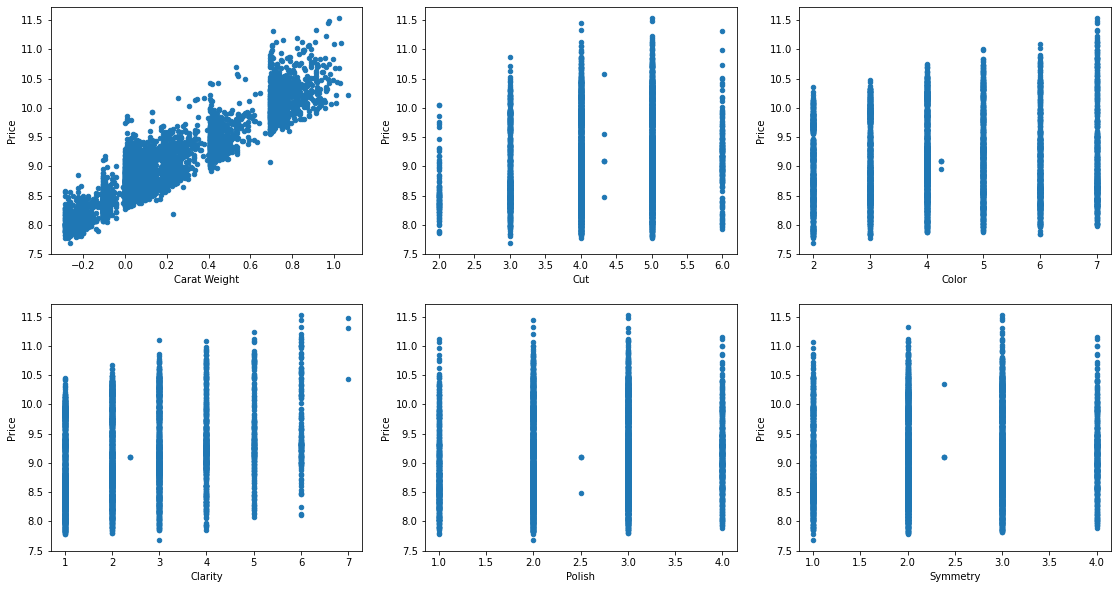

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(19, 10))
for idx, feature in enumerate(train_copy.columns[:-1]):
    train_copy.plot(feature, "Price", subplots=True, kind="scatter", ax=axes[idx // 3, idx % 3])

Действительно, удалось уменьшить явление гетероскедастичности и уменьшить разброс дисперсии. Посмотрим на гистограмму и "ящик с усами".

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, '"Ящик с усами" после log-трансформации цены')

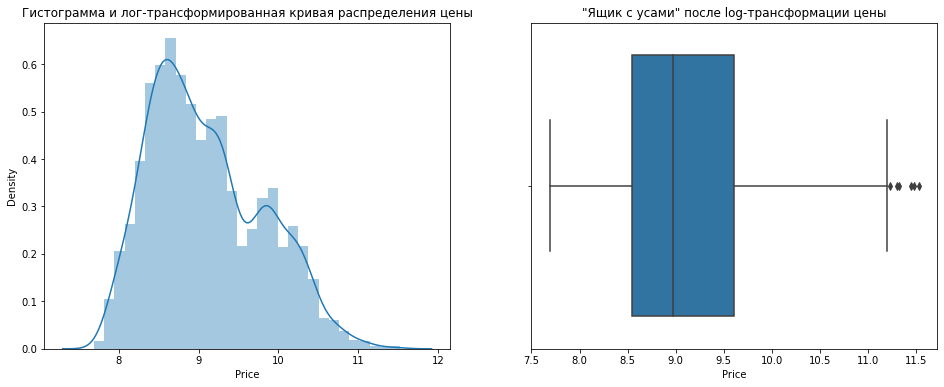

In [32]:
plt.figure(figsize = (16, 6))

pylab.subplot(1,2,1)
sns.distplot(train_copy['Price'])
pylab.title('Гистограмма и лог-трансформированная кривая распределения цены')

pylab.subplot(1,2,2)
sns.boxplot(train_copy['Price'])
pylab.title('"Ящик с усами" после log-трансформации цены')

По графикам можно видеть что log-трансформация помогла уменьшить количество выбросов, уменьшить асимметрию вправо, а также приблизило распределение к нормальному. Дабы не быть голословным, проверим это аналитически.

Воспользуемся критерием нормальности Д'Агостино и Пирсона из библиотеки scipy. За H0-гипотезу примем то, что распределение цены нормальное. За H1, соответсвенно, что не нормальное. За теоретический уровень значимости примем альфу равную 0.01. Если вычисленный уровень значимости p будет меньше альфы, то отвергаем гипотезу H0 => распределение не нормальное.

In [33]:
stats.normaltest(train_copy['Price'])

k2, p = stats.normaltest(train_copy['Price'])
alpha = 1e-3
print("p = {:g}".format(p))
if p < alpha:  # Нулевая гипотеза о том, что распределение цены происходит из нормального распределения
    print("Нулевая гипотеза отвергается")
else:
    print("Нулевая гипотеза не отвергается")

p = 3.97478e-56
Нулевая гипотеза отвергается


Распределение цены не нормальное. Проверим еще на одном критерии - Лиллиефорса.

In [34]:
import statsmodels.api as sm
sm.stats.lilliefors(train_copy['Price'])

(0.0750653393582979, 0.0009999999999998899)

Он является модификацией критерия Колмогорова-Смирнова для значений, когда есть смещение мат.ожидания и дисперсии от 0 и 1 соответственно. Теоретическое критическое значение при размере нашей выборки равно 0.015. Если второе наше значение меньше 0.015, то гипотеза H0 о том, что наше распределение нормальное отвергается. Что соответствует нашему случаю.

Также проверим значение правой асимметрии

In [35]:
train_copy['Price'].skew()

0.511437300164388

Оно действительно уменьшилось, что нам на руку. Перейдем к обучению модели.

### Простая линейная регрессия

Разделим выборку на обучающую в которой будет находиться 80% данных и на валидационную, в которой будет 20% данных. В качестве метрики качества будем использовать среднеквадратичную ошибку и среднюю абсолютную ошибку в процентах.

In [36]:
train_copy_X = train_copy.drop(['Price'], axis=1)
train_copy_y = train_copy['Price']

In [37]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(train_copy_X, train_copy_y, test_size=0.2, random_state=50)

In [38]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
predictions = linear_regressor.predict(X_valid)

In [39]:
mean_squared_error(y_valid, predictions)

0.011139018752909634

In [40]:
np.mean(np.abs((y_valid - predictions) / y_valid)) * 100

0.8956429898389993

In [41]:
resid = y_valid - predictions
resid.mean()

-0.0012894670971888642

In [42]:
import statsmodels.api as sm
sm.stats.lilliefors(resid)

(0.027609922519094665, 0.1260828244988727)

In [43]:
X_train.corrwith(resid, method='pearson')

Carat Weight   NaN
Cut            NaN
Color          NaN
Clarity        NaN
Polish         NaN
Symmetry       NaN
Report_GIA     NaN
dtype: float64

Text(0, 0.5, 'Predicted Y')

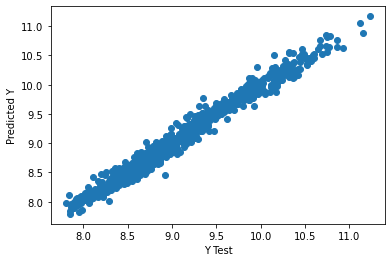

In [44]:
plt.scatter(y_valid, predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [45]:
np.corrcoef(y_valid, predictions)

array([[1.       , 0.9886064],
       [0.9886064, 1.       ]])

Как видно по метрикам качества, модель хорошо предсказывает цену. Ошибка спрогнозированных значений не превышает 9%. 
Коэффициент $R^2$, также показывает хороший результат. Также были проверены предположения об ошибках, которые должны выполняться, если вы хотите, чтобы ваша модель выполняла свои функции хорошо. Во-первых, у ошибок нет корреляции с признаками. Во-вторых, ошибки нормально распределены. В-третьих мат. ожидание ошибок близко к нулю. Но попробуем улучшить результат построив модель полиномиальной регрессии второй степени.

In [46]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly = poly_features.fit_transform(X_train)
X_valid_poly = poly_features.transform(X_valid)

In [47]:
lm_poly = LinearRegression()

In [48]:
lm_poly.fit(X_train_poly, y_train)

predictions_poly = lm_poly.predict(X_valid_poly)

Text(0, 0.5, 'Predicted Y')

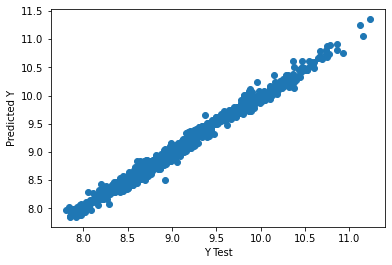

In [49]:
plt.scatter(y_valid,predictions_poly)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [50]:
mean_squared_error(y_valid, predictions_poly)

0.006118280143595965

In [51]:
np.mean(np.abs((y_valid - predictions_poly) / y_valid)) * 100

0.6738432199656392

In [52]:
np.corrcoef(y_valid, predictions_poly)

array([[1.        , 0.99375436],
       [0.99375436, 1.        ]])

In [53]:
resid_poly = y_valid - predictions_poly
resid_poly.mean()

1.635294580303734e-05

In [54]:
import statsmodels.api as sm
sm.stats.lilliefors(resid_poly)

(0.025163289918478132, 0.22299867622941388)

Добавлением к регрессии второй степени удалось улучшить метрики качества. Также, как в предыдущем пункте были соблюдены необходимые предположения об ошибках. А следовательно модель справилась со своей задачей и хорошо спрогнозировала значения. Наконец, спрогнозируем цену на 1500 бриллиантов без цены.

### Прогноз цены на тестовой выборке

Так как полиномиальная регрессия показала лучший результат - будем использовать эту модель для прогноза.

In [55]:
test_copy = test.copy()

In [56]:
test_copy = test_copy.fillna(test_copy.mean())

In [57]:
test_copy['Carat Weight'] = np.log(test_copy['Carat Weight'])

In [58]:
test_copy_X = test_copy.drop(['Price'], axis=1)
test_copy_y = test_copy['Price']

In [59]:
X_test_poly = poly_features.transform(test_copy_X)

In [60]:
predictions_test = lm_poly.predict(X_test_poly)

In [61]:
test_predictions_poly = np.exp(predictions_test)
test_copy['Carat Weight'] = np.exp(test_copy['Carat Weight'])

In [62]:
test_copy['Price'] = test_predictions_poly  

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  w

Text(0.5, 1.0, '"Ящик с усами" цены')

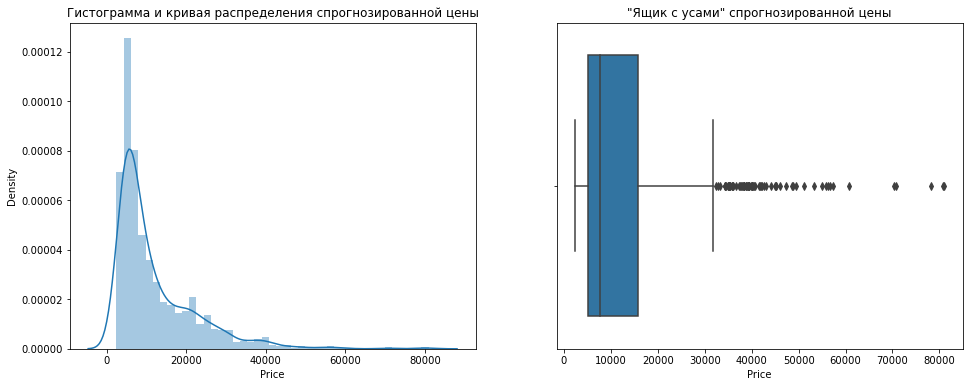

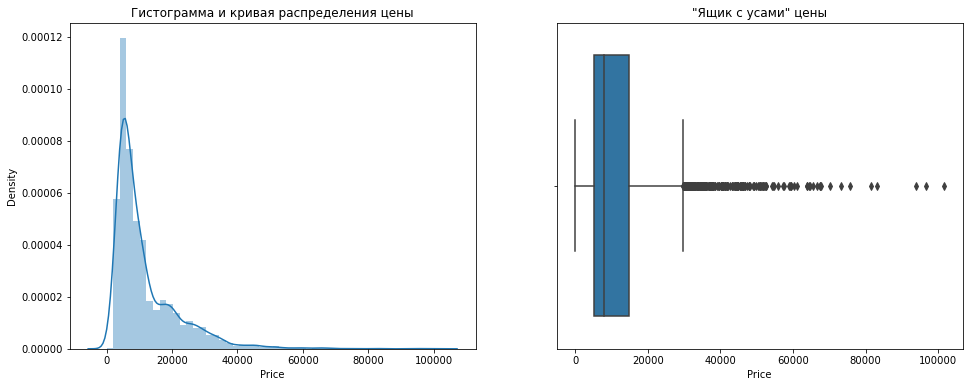

In [63]:
plt.figure(figsize = (16, 6))

pylab.subplot(1,2,1)
sns.distplot(test_copy['Price'])
pylab.title('Гистограмма и кривая распределения спрогнозированной цены')

pylab.subplot(1,2,2)
sns.boxplot(test_copy['Price'])
pylab.title('"Ящик с усами" спрогнозированной цены')

plt.figure(figsize = (16, 6))

pylab.subplot(1,2,1)
sns.distplot(train['Price'])
pylab.title('Гистограмма и кривая распределения цены')

pylab.subplot(1,2,2)
sns.boxplot(train['Price'])
pylab.title('"Ящик с усами" цены')

In [64]:
test_copy.describe()

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Price,Report_GIA
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,1.344167,4.358906,4.258172,2.347565,2.518667,2.414276,11964.772823,0.883333
std,0.477557,0.822024,1.546065,1.364742,0.779352,0.841603,10254.007438,0.321130
min,0.750000,2.000000,2.000000,1.000000,1.000000,1.000000,2380.604783,0.000000
25%,1.010000,4.000000,3.000000,1.000000,2.000000,2.000000,5123.224905,1.000000
50%,1.140000,4.000000,4.000000,2.000000,3.000000,2.000000,7743.171340,1.000000
75%,1.620000,5.000000,5.000000,3.000000,3.000000,3.000000,15769.942381,1.000000
max,2.820000,6.000000,7.000000,7.000000,4.000000,4.000000,80985.260795,1.000000


In [65]:
train.describe()

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Price,Report_GIA
count,4498.000000,4497.000000,4499.000000,4500.000000,4499.000000,4499.000000,4498.000000,4500.000000
mean,1.331274,4.329553,4.255835,2.376667,2.503890,2.386530,11680.771240,0.875778
std,0.475013,0.819524,1.566840,1.372300,0.805534,0.871313,10063.376832,0.329872
min,0.750000,2.000000,2.000000,1.000000,1.000000,1.000000,0.001000,0.000000
25%,1.000000,4.000000,3.000000,1.000000,2.000000,2.000000,5128.750000,1.000000
50%,1.130000,4.000000,4.000000,2.000000,3.000000,2.000000,7871.000000,1.000000
75%,1.580000,5.000000,5.000000,3.000000,3.000000,3.000000,14952.250000,1.000000
max,2.910000,6.000000,7.000000,7.000000,4.000000,4.000000,101561.000000,1.000000


Итак, удалось спрогнозировать цены на бриллианты. Как видно на графиках и на статистиках модель хорошо спрогнозировала цены на бриллианты.